In [131]:
# IMPORT LIBRARIES 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [253]:
from dotenv import load_dotenv
load_dotenv()
UR_API_KEY = os.getenv('DB_ID')
UR_API_SECRET = os.getenv('DB_SECRET')
USERNAME = os.getenv('DB_USER')


In [254]:
# log it to spotify
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.oauth2 as oauth2
from spotipy.oauth2 import SpotifyOAuth

token = oauth2.SpotifyClientCredentials(
    client_id=UR_API_KEY,
    client_secret=UR_API_SECRET)
sp = spotipy.Spotify(client_credentials_manager=token)


In [255]:
# user authorization on spotipy in order to push our new playlists

import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy
import spotipy.util as util

cid = UR_API_KEY  # Client ID;
secret = UR_API_SECRET  # Client Secret;
username =USERNAME   # got from Spotify->account settings
#for avaliable scopes see https://developer.spotify.com/web-api/using-scopes/
scope = 'user-library-read playlist-modify-public playlist-read-private'
redirect_uri = 'http://localhost:3000/callback'  # works on 3000,8888 as well
client_credentials_manager = SpotifyClientCredentials(
    client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
token = util.prompt_for_user_token(username, scope, cid, secret, redirect_uri)
if token:
 sp = spotipy.Spotify(auth=token)
else:
 print("Can't get token for", username)
# results = sp.current_user_saved_tracks()


In [ ]:
# get a list with music genres
genres = sp.recommendation_genre_seeds()
atmosferika = [ "your genres here"]
# get every song from an artist
def get_artists_from_genre(genrelist):
    artists = []

    for genre in genrelist:
        results = sp.search(q='genre:' + genre, type='artist', limit=50)
        for i, t in enumerate(results['artists']['items']):
            artists.append(t['name'])

    return artists

def get_songs_from_genre(genrelist):
    artistlist = get_artists_from_genre(genrelist)
    songs = []
    songs_names = []
    songs_artists = []
    Audio_Features = []
    for artist in artistlist:
        results = sp.search(q='artist:' + artist, type='track', limit=20)
        for i, t in enumerate(results['tracks']['items']):
            songs.append(t['id'])
            songs_names.append(t['name'])
            songs_artists.append(t['artists'][0]['name'])
            Audio_Features.append(sp.audio_features(t['id'])[0])

    return {'songs': songs, 'songs_names': songs_names, 'songs_artists': songs_artists, 'Audio_Features': Audio_Features}


songslist_atmosferika = get_songs_from_genre(atmosferika)

songslist_atmosferika


In [168]:
songslist_atmosferika2 = songslist_atmosferika.copy()


In [186]:
songslist_atmosferika2['Audio_Features'].pop(1947)
songslist_atmosferika2['songs'].pop(1947)
songslist_atmosferika2['songs_names'].pop(1947)
songslist_atmosferika2['songs_artists'].pop(1947)
"0SkmMypdFPCHxb14kQ8Uqt"


'Itoko Toma'

In [187]:
# convert all to dataframe
# AttributeError: 'NoneType' object has no attribute 'keys'
Audio_Features_df = pd.DataFrame(songslist_atmosferika2["Audio_Features"]
             )

songs_df = pd.DataFrame(
    {'id': songslist_atmosferika2["songs"], 'song_name': songslist_atmosferika2["songs_names"], 'artist': songslist_atmosferika2["songs_artists"]})
# merge the two dataframes
songslist_atmosferika2 = pd.merge(songs_df, Audio_Features_df, on='id')




In [188]:
    # clean the data
songslist_atmosferika2 = songslist_atmosferika2.drop(
    ['analysis_url', 'track_href', 'type', 'uri', 'id_y', 'duration_ms', 'time_signature', ], axis=1, errors='ignore')
songslist_atmosferika2.rename(columns={'id_x': 'id'}, inplace=True)
songslist_atmosferika2["fullname"] = songslist_atmosferika2["song_name"] + \
    " - " + songslist_atmosferika2["artist"]
songslist_atmosferika2.drop_duplicates(subset="fullname", keep=False, inplace=True)
songslist_atmosferika2.drop(['song_name', 'artist'], axis=1, inplace=True)
songslist_atmosferika2.set_index('id', inplace=True)
songslist_atmosferika2.info()


<class 'pandas.core.frame.DataFrame'>
Index: 5106 entries, 6qUlFwX2Jox8BgQJiaI6U7 to 4sakBPqSpuj6FJti1rPme7
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      5106 non-null   float64
 1   energy            5106 non-null   float64
 2   key               5106 non-null   int64  
 3   loudness          5106 non-null   float64
 4   mode              5106 non-null   int64  
 5   speechiness       5106 non-null   float64
 6   acousticness      5106 non-null   float64
 7   instrumentalness  5106 non-null   float64
 8   liveness          5106 non-null   float64
 9   valence           5106 non-null   float64
 10  tempo             5106 non-null   float64
 11  fullname          5106 non-null   object 
dtypes: float64(9), int64(2), object(1)
memory usage: 518.6+ KB


In [189]:
# save to csv
songslist_atmosferika2.to_csv('songs_df_dunata.csv')


In [228]:
# SCALING DATA
songslist_atmosferika2 = songslist_atmosferika2.drop(['fullname'], axis=1, errors='ignore')
scaler = MinMaxScaler()
songs_scaled = scaler.fit_transform(songslist_atmosferika2)
songs_scaled = pd.DataFrame(
    songs_scaled, columns=songslist_atmosferika2.columns, index=songslist_atmosferika2.index)



In [229]:
# remove low energy songs
songs_scaled = songs_scaled[songs_scaled['energy'] > 0.2]
# remove low danceability songs
songs_scaled = songs_scaled[songs_scaled['danceability'] > 0.3]


In [ ]:
# validation through silhouette score
from sklearn.metrics import silhouette_score
# run it for 6 to 30 clusters and plot it
silhouette_scores = []
#apply the k mean algorithm for any possible number of k to choose the best one
for i in range(10, 18):
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(songs_scaled)
    silhouette_scores.append(silhouette_score(songs_scaled, km.labels_))

plt.plot(range(10, 18), silhouette_scores)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")


c:\Users\mrpal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<AxesSubplot: >

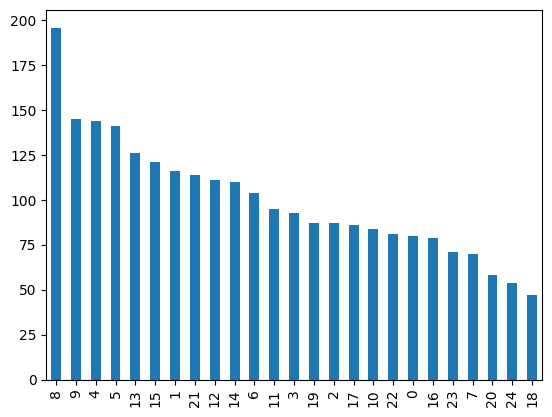

In [235]:
# RUN THE KMEANS ALGORITHM MULTIPLE TIMES IN ORDER TO GET THE BEST inertia_
from sklearn.cluster import KMeans
# for i in range(30):
#     km = KMeans(n_clusters=12, random_state=i)
#     km.fit(songs_scaled)
#     print(i, km.inertia_)
# we go for random_state=0
km = KMeans(n_clusters=25, random_state=0
            )
km.fit(songs_scaled)
songs_scaled["cluster"] = km.labels_
songs_scaled["cluster"].value_counts()
songs_scaled["cluster"].value_counts().plot(kind="bar")

In [ ]:
# GaussianMixture version

# from sklearn.mixture import GaussianMixture
# from numpy import unique
# from numpy import where
# from matplotlib import pyplot

# # define the model
# gaussian_model = GaussianMixture(n_components=12)

# # train the model
# gaussian_model.fit(songs_scaled)

# # assign each data point to a cluster
# gaussian_result = gaussian_model.predict(songs_scaled)

# # get all of the unique clusters
# gaussian_clusters = unique(gaussian_result)
# for gaussian_cluster in gaussian_clusters:
#     # get data points that fall in this cluster
#     index = where(gaussian_result == gaussian_clusters)
#     # make the plot

# songs_scaled["cluster"] = gaussian_result
# # show the Gaussian Mixture plot
# songs_scaled["cluster"].value_counts()
# songs_scaled["cluster"].value_counts().plot(kind="bar")


In [240]:
songs_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2500 entries, 6ukaBMbCvSB1SHq1FdUnPp to 5PGtbjfmWEfKkj2XrYNSSo
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      2500 non-null   float64
 1   energy            2500 non-null   float64
 2   key               2500 non-null   float64
 3   loudness          2500 non-null   float64
 4   mode              2500 non-null   float64
 5   speechiness       2500 non-null   float64
 6   acousticness      2500 non-null   float64
 7   instrumentalness  2500 non-null   float64
 8   liveness          2500 non-null   float64
 9   valence           2500 non-null   float64
 10  tempo             2500 non-null   float64
 11  cluster           2500 non-null   int32  
dtypes: float64(11), int32(1)
memory usage: 244.1+ KB


In [ ]:
# #create a list with the cluster names
# cluster_dict ={}
# for i in range(12):  
#     # cluster_dict[i] = "cluster_" + str(i)
#     cluster_dict[i] = songs_scaled.loc[songs_scaled["cluster"] == i].index.tolist()
    


# for i in range(25):
#     print("+  "+str(songs_scaled.loc[songs_scaled["cluster"] == i].energy.mean()))



In [249]:
# choosing the best clusters
for i in range(25):
    print("d "+str(songs_scaled.loc[songs_scaled["cluster"]
          == i].danceability.mean()))
songs_scaled.loc[songs_scaled["cluster"]
                 == 0].reset_index().to_csv('cluster_dance.csv')


In [ ]:

# tracks = sp.user_playlist_tracks(
#     user='spotify', playlist_id='74YuefRmDofqGQGDonQkSl')
# tracks["items"][5]["track"]["name"]

# get user 
# create post request using spotipy 
# get the playlist id
# curl - X "GET" "https://api.spotify.com/v1/me"
# - H "Accept: application/json"
# - H "Content-Type: application/json" - H "Authorization: Bearer "
# sp me
# https://api.spotify.com/v1/users/{user_id}/playlists
# https://api.spotify.com/v1/playlists/{playlist_id}/tracks
# sp.user_playlist_create("11133611811", "skta", public=True, description=None)
# sp.user_playlist_add_tracks(user, playlist_id, tracks, position=None)
# sp.user_playlist_tracks(user, playlist_id, fields=None, limit=100, offset=0, market=None)





In [233]:
songs_raw = songs_scaled.reset_index()
songs_raw


,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
0,6ukaBMbCvSB1SHq1FdUnPp,0.337102,0.226181,0.818182,0.573394,0.0,0.051408,0.987952,0.909729,0.109744,0.090545,0.403017,1
1,1aP2Tz8l7z7tfDzKMnaOb4,0.456321,0.218173,0.181818,0.530091,1.0,0.049218,0.992972,0.892678,0.091179,0.078006,0.425725,3
2,03fImIJ7r7he62QmwI1Tyv,0.539568,0.209163,0.636364,0.794102,1.0,0.046090,0.831325,0.929789,0.073026,0.970195,0.559345,3
3,6UKrqWqzDTCYBCH2OXAMC3,0.655704,0.384349,0.636364,0.836447,1.0,0.049009,0.929719,0.342026,0.451282,0.787256,0.403138,5
4,4qRHwcsUkrYFZe2fOlcrAR,0.478931,0.554529,0.181818,0.825736,0.0,0.033577,0.812249,0.715145,0.213333,0.423433,0.338861,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,4iHcmWi4kGGNCEk44ZIXIc,0.536485,0.538512,0.636364,0.794007,1.0,0.028676,0.707831,0.000007,0.346667,0.379239,0.629127,5
2496,6quygE0BQuMUY861Crte1N,0.640288,0.220175,0.181818,0.654826,1.0,0.044108,0.816265,0.000058,0.109744,0.488181,0.548477,5
2497,01X80L2kxCSfyclTCbpfX2,0.571429,0.221176,0.181818,0.729570,1.0,0.038582,0.755020,0.000000,0.075590,0.550874,0.644964,5
2498,6XPLnH0wby09UGaJYtv4NT,0.556012,0.242198,1.000000,0.663314,1.0,0.037018,0.869478,0.046239,0.113846,0.560123,0.661171,5


In [ ]:
# create a playlist for each cluster
songs_raw = songs_scaled.reset_index()
songs_raw
for i in range(12):
    ids = songs_raw[songs_raw["fullname"].isin(cluster_dict[i])]["id"].tolist()

   # maximun 100 songs per playlist
    if len(ids) > 100:
        ids = ids[:100]
        sp.user_playlist_create("11133611811", "cluster_" + str(i), public=True, description=None)
        playlist_id = sp.user_playlists("11133611811")["items"][i]["id"]
        
    
        # prevent a 400 error 
        try: 
            sp.user_playlist_add_tracks("11133611811", playlist_id, ids)
            print("cluster_" + str(i) + " created")
        except:
            print("error")  
    
#find the id through the first dataframe



NameError: name 'songs_raw' is not defined